# Unsupervised Learning Capstone: *Text Classification*

The outline for the notebook is as follows:
1. Selection and Cleaning of 15 Texts
2. Emphasis on Text as Word Choice per Sentence
    1. Preparing Data
    2. Splitting Texts into Train-Test Groups
    2. Feature Creation and Engineering
    3. Clustering
    4. Classification Models
3. Emphasis on Text as Paragraphs
    1. Preparing Data
    2. Splitting Texts into Train-Test Groups
    2. Feature Creation and Engineering
    3. Clustering
    4. Classification Models
4. Assessing and Tuning Highest Potential Approach
5. Testing Tuned Approaches on Holdout
6. Conclusion

## Section 1: Selection and Cleaning of 10 Texts
For this project, we will be analyzing and classifying the inaugural addresses - a speech given during president's inauguration for the purpose of informing the people of their intentions as a leader - of presidents of the United States of America. In order to avoid having too many classification categories and have similarly-sized amounts of data for each president, we have limited the text sources to the inaugural addresses of the 15 American presidents who were elected for more than one term and gave a second inaugural address (with the exception of Obama since the last address available is from his first term in 2009). These presidents, along with their years of address, are as follows: 
1. Washington (1789 and 1793)
2. Jefferson (1801 and 1805)
3. Madison (1809 and 1813) 
4. Monroe (1817 and 1821)
5. Jackson (1829 and 1833)
6. Lincoln (1861 and 1865)
7. Grant (1869 and 1873)
8. McKinley (1897 and 1901)
9. Wilson (1913 and 1917)
10. Roosevelt (1933 and 1937) *
11. Eisenhower (1953 and 1957)
12. Nixon (1969 and 1973)
13. Reagan (1981 and 1985)
14. Clinton (1993 and 1997)
15. Bush Jr. (2001 and 2005).

** For consistency, we will only be using the first two inaugural addresses from Roosevelt (therefore, excluding the years 1941 and 1945) in order to have two addresses per president. These first two addresses were chosen for two reasons: (1) they contained the greatest amount of text and, thus, the largest amount of information and (2) all other presidents gave consecutive addresses starting with their intial term.*

In [1]:
import numpy as np
import pandas as pd

from nltk.corpus import inaugural, stopwords
import re
import spacy

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from collections import Counter
import itertools

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering

from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn import ensemble
from sklearn import svm

from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import cross_val_score

In [2]:
# Selecting all consecutive addresses for select presidents
speeches = ['1789-Washington.txt','1793-Washington.txt','1801-Jefferson.txt','1805-Jefferson.txt',
            '1809-Madison.txt','1813-Madison.txt','1817-Monroe.txt','1821-Monroe.txt',
            '1829-Jackson.txt','1833-Jackson.txt','1861-Lincoln.txt','1865-Lincoln.txt',
            '1869-Grant.txt','1873-Grant.txt','1897-McKinley.txt','1901-McKinley.txt',
            '1913-Wilson.txt','1917-Wilson.txt','1933-Roosevelt.txt','1937-Roosevelt.txt',
            '1953-Eisenhower.txt','1957-Eisenhower.txt','1969-Nixon.txt','1973-Nixon.txt',
            '1981-Reagan.txt','1985-Reagan.txt','1993-Clinton.txt','1997-Clinton.txt',
            '2001-Bush.txt','2005-Bush.txt']

# Creating a list of relevant, unique names to identify each address specifically
speech_names = []
for name in speeches:
    speech_names.append(re.sub("[^a-zA-Z]",'',name[5:-4]).lower() +'_'+ re.sub("",'',name[:4]))

# Loading all addresses within list 'speeches' and titling each according to list 'speech_names'
address={}
for speech_name, speech in zip(speech_names, speeches):
    address[speech_name] = inaugural.raw(speech)

print('For this project, {} addresses will be used.'.format(len(address)))

For this project, 30 addresses will be used.


In [3]:
# Loading dictionary into DataFrame for text-cleaning
df = pd.DataFrame.from_dict(address, orient='index', columns=['address'])

# Creating list and adding to DataFrame for target variable of the president's name
president_names = [x[:-5] for x in df.index]
df['target'] = president_names

df.head()

,address,target
washington_1789,Fellow-Citizens of the Senate and of the House...,washington
washington_1793,"Fellow citizens, I am again called upon by the...",washington
jefferson_1801,Friends and Fellow Citizens:\n\nCalled upon to...,jefferson
jefferson_1805,"Proceeding, fellow citizens, to that qualifica...",jefferson
madison_1809,Unwilling to depart from examples of the most ...,madison


## Section 2: Emphasis on Text as Word Choice per Sentence
### Subsection 2A: Preparing Data

In [4]:
# Defining function for cleaning text
def text_cleaner(text):
    '''Function that cleans text by removing unnecessary characters.'''
    text = re.sub(r'--',' ',text) # Removes double-dash which is incompatible with spaCy
    text = re.sub("[\[].*?[\]]", "", text) # Removes line, paragraph, tab breaks
    text = ' '.join(text.split()) # Removes excess white space
    return text

# Creating list of cleaned addresses according to function 'text_cleaner'
cleaned = [text_cleaner(address) for address in df.address]

# Replacing old text data of addresses with cleaned text data
df['address'] = cleaned
df.head()

,address,target
washington_1789,Fellow-Citizens of the Senate and of the House...,washington
washington_1793,"Fellow citizens, I am again called upon by the...",washington
jefferson_1801,Friends and Fellow Citizens: Called upon to un...,jefferson
jefferson_1805,"Proceeding, fellow citizens, to that qualifica...",jefferson
madison_1809,Unwilling to depart from examples of the most ...,madison


In [5]:
# Parse the cleaned addresses
nlp = spacy.load('en')

# Creating list for parsed addresses
parsed = [nlp(address) for address in df.address]

# Replacing cleaned text with parsed text
df['address'] = parsed
df.head()

,address,target
washington_1789,"(Fellow, -, Citizens, of, the, Senate, and, of...",washington
washington_1793,"(Fellow, citizens, ,, I, am, again, called, up...",washington
jefferson_1801,"(Friends, and, Fellow, Citizens, :, Called, up...",jefferson
jefferson_1805,"(Proceeding, ,, fellow, citizens, ,, to, that,...",jefferson
madison_1809,"(Unwilling, to, depart, from, examples, of, th...",madison


In [6]:
# Creating for loop create DataFrame of address sentences with respective target president from address paragraphs
sentences = pd.DataFrame()
for x in range(0, len(df.address)):
    if x == 0:
        sentences['sentences'] = [sent for sent in df.address[x].sents]
        sentences['president'] = df.target[x]
    else:
        temporary = pd.DataFrame()
        temporary['sentences'] = [sent for sent in df.address[x].sents]
        temporary['president'] = df.target[x]
        sentences = sentences.append(temporary)
        sentences = sentences.reset_index(drop=True)

sentences.tail()

,sentences,president
2362,"(It, rang, as, if, it, meant, something.¡¨)",bush
2363,"(In, our, time, it, means, something, still, .)",bush
2364,"(America, ,, in, this, young, century, ,, proc...",bush
2365,"(Renewed, in, our, strength¡Xtested, ,, but, n...",bush
2366,"(May, God, bless, you, ,, and, may, He, watch,...",bush


### Subsection 2B: Train-Test Split

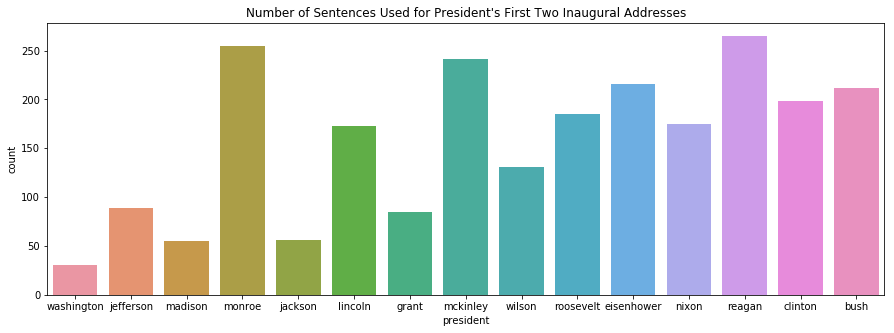

reagan        265
monroe        255
mckinley      241
eisenhower    216
bush          212
clinton       198
roosevelt     185
nixon         175
lincoln       173
wilson        131
jefferson      89
grant          85
jackson        56
madison        55
washington     31
Name: president, dtype: int64

In [7]:
# Previewing the sentence-to-president distribution
plt.figure(figsize=[15,5])
sns.countplot(x=sentences.president)
plt.title("Number of Sentences Used for President's First Two Inaugural Addresses")
plt.show()
sentences.president.value_counts()

For our initial testing, we want to ensure that our model is exposed to the full gambit of selected presidents. Therefore, we will stratify our train-test split across sentence-to-president distribution. 

The order from left-to-right above is in chronological presidency, and it is interesting to note the general trend of sentence increase in presidents. We will probably run into problems with model accuracy with the unequal distributions for presidents like Washington since the amount of data of his that is exposed to our model is minimal compared to, say, Reagan.

In [8]:
X = sentences['sentences']
y = sentences['president']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    stratify=y, # to ensure all presidents are in train and test
                                                    test_size=0.25, 
                                                   random_state=0)

In [9]:
y_test.value_counts()

reagan        66
monroe        64
mckinley      60
eisenhower    54
bush          53
clinton       50
roosevelt     46
nixon         44
lincoln       43
wilson        33
jefferson     22
grant         21
madison       14
jackson       14
washington     8
Name: president, dtype: int64

### Subsection 2C: Feature Creation and Engineering

In [10]:
# Defining functions for Bag of Words and BoW Features for later modeling
def bag_of_words(text):
    '''Utility function to create a list of the 2000 most common words'''
    # Filter out punctuation and stop words.
    allwords = [token.lemma_ for token in text if not token.is_punct and not token.is_stop]
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(50)]
    
def bow_features(sentences, common_words):  
    '''Creates DataFrame where feature is each common word and feature value is word count in sentence'''
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences['sentences']
    df['text_source'] = sentences['president']
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        words = [token.lemma_     # Convert the sentence to lemmas
                 for token in sentence
                 if (             # Filter out punctuation, stop words, and uncommon words
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        for word in words:        # Populate the row with word counts
            df.loc[i, word] += 1
        if i % 100 == 0:           # Counter to make sure the kernel didn't hang
            print("Processing row {}".format(i))
    return df

words_list = []
for x in range(0, len(df.address)):
    words_list.append(bag_of_words(df['address'][x]))

common_words = set(list(itertools.chain.from_iterable(words_list)))

In [11]:
# Concatenating training data for BoW function input
train_sentences = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)

# Creating feature word counts 
word_counts = bow_features(train_sentences, common_words)

Processing row 0
Processing row 100
Processing row 200
Processing row 300
Processing row 400
Processing row 500
Processing row 600
Processing row 700
Processing row 800
Processing row 900
Processing row 1000
Processing row 1100
Processing row 1200
Processing row 1300
Processing row 1400
Processing row 1500
Processing row 1600
Processing row 1700


### Subsection 2D: Clustering

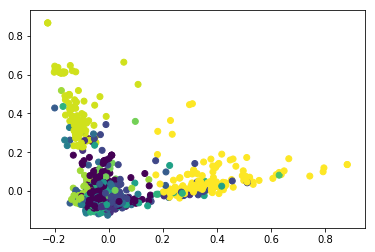

Comparing k-means clusters against the data:
col_0         0   1   2   3   4   5   6   7   8   9   10  11  12  13  14
text_source                                                             
bush          92   0   0   3   3   0   3   0   8  10   0   3  17  14   6
clinton       86   0   2   0   2   0   1   0  12   7   0   4  17   5  12
eisenhower    84   0   6   2   0   0  10   0   6   4   1   5   4  18  22
grant         37   0   2   3   2   3   2   1   0   1   0   1   0   6   6
jackson       14   0   7   3   0   6   0   1   1   4   0   1   0   3   2
jefferson     44   0   5   0   1   3   3   0   0   8   0   1   0   2   0
lincoln       75   0  11   7   4   7   1  12   1   1   0   1   0   0  10
madison       25   0   0   5   0   2   0   0   1   1   0   1   0   4   2
mckinley      93   0   9  17   6  18   1   0   3   1   0   5   0   5  23
monroe        82   0   7  28   7  10   3   2   5  13   0   9   0  10  15
nixon         68   0   4   1   9   1   8   0   7   2   1   2  11   8   9
reagan

In [12]:
# Clustering with KMeans
y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

# Normalize the data.
X_norm = normalize(X)

# Reduce it to two components.
X_pca = PCA(2).fit_transform(X_norm)

# Calculate predicted values.
y_pred = KMeans(n_clusters=15, random_state=0).fit_predict(X_norm)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y, y_pred))

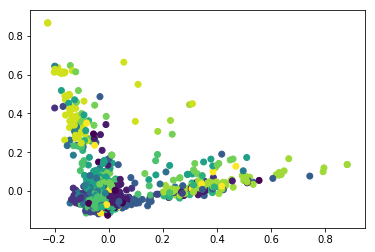

Comparing the assigned categories to the ones in the data:
col_0       0   1   2   3   4   5   6   7   8   9    10  11  12  13  14
president                                                              
bush         1   3  12  10   8   8   0   1   8   0   80   7   2  13   6
clinton      3   0  11   8   7  20   0   1  16   2   55   2   7   6  10
eisenhower   3   2   4   4   0   7   5   1  13   9   75   6  14  12   7
grant        4   2   0   2   4   2   1   0   0   3   36   3   2   4   1
jackson      8   2   0   4   3   0   1   0   1   7   12   1   0   2   1
jefferson    2   0   0   8   4   1   2   0   2   5   39   2   0   2   0
lincoln     13   8   0   2   2   5   5   0   1   9   75   2   7   0   1
madison      1   3   0   2   0   1   9   0   2   0   17   1   2   2   1
mckinley    19  15   0   3   3   4   6   0   3  14   83  10  14   4   3
monroe      14  28   1  14   4   4  10   0   0   6   72  23   7   4   4
nixon        3   1   9   2   8  16   6   1  17   5   46   4   4   4   5
reaga

In [13]:
# Clustering with Spectral Clustering
sc = SpectralClustering(n_clusters=15)
sc.fit(X_norm)

# Predicted clusters.
predict=sc.fit_predict(X_norm)

# Graph results.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predict)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train,predict))

### Subsection 2E: Classification Models

In [14]:
# Creating train-test split of original training data
Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0)

In [15]:
# Assessing potential of Logistic Regression
logistic = LogisticRegression()
logistic.fit(X_train, y_train)
print('Training set score:', logistic.score(X_train, y_train))
print('\nTest set score:', logistic.score(X_test, y_test))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Training set score: 0.8150234741784037

Test set score: 0.35352112676056335


In [16]:
cross_val_score(logistic, X, Y, cv=5)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default so

array([0.31491713, 0.3547486 , 0.36619718, 0.32102273, 0.37643678])

In [17]:
# Assessing potential of K-Nearest Neighbors Classifier
knn = neighbors.KNeighborsClassifier(weights='distance', n_neighbors=15)
knn.fit(normalize(X_train), y_train)
print('Training set score:', knn.score(normalize(X_train), y_train))
print('\nTest set score:', knn.score(normalize(X_test), y_test))

Training set score: 0.9502347417840376

Test set score: 0.11690140845070422


In [18]:
# Assessing potential of Random Forest Classifier
rfc = ensemble.RandomForestClassifier(random_state=0)
rfc.fit(X_train, y_train)
print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training set score: 0.9380281690140845

Test set score: 0.24084507042253522


In [19]:
# Assessing potential of Support Vector Machine Classifier
svc = svm.SVC(kernel='linear')
svc.fit(X_train, y_train)
print('Training set score:', svc.score(X_train, y_train))
print('\nTest set score:', svc.score(X_test, y_test))

Training set score: 0.8845070422535212

Test set score: 0.2591549295774648


### Subsection 2F: Classification Models with Limited Presidents

In [20]:
limited = ['lincoln','grant','mckinley','wilson','roosevelt','eisenhower','nixon','reagan','clinton','Bush']
limited_presidents = word_counts[word_counts.text_source.isin(limited)]

y = limited_presidents['text_source']
X = limited_presidents.drop(['text_sentence','text_source'], 1)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.4,
                                                    random_state=0)

In [21]:
# Assessing potential of Logistic Regression
logistic = LogisticRegression(solver='liblinear', multi_class='auto')
logistic.fit(X_train, y_train)
print('Training set score:', logistic.score(X_train, y_train))
print('\nTest set score:', logistic.score(X_test, y_test))

Training set score: 0.8029294274300932

Test set score: 0.3992015968063872


In [22]:
cross_val_score(logistic, X, y, cv=5)

array([0.32677165, 0.40079365, 0.43824701, 0.35742972, 0.44715447])

In [23]:
# Assessing potential of K-Nearest Neighbors Classifier
knn = neighbors.KNeighborsClassifier(weights='distance', n_neighbors=15)
knn.fit(normalize(X_train), y_train)
print('Training set score:', knn.score(normalize(X_train), y_train))
print('\nTest set score:', knn.score(normalize(X_test), y_test))

Training set score: 0.9454061251664447

Test set score: 0.1936127744510978


In [24]:
# Assessing potential of Random Forest Classifier
rfc = ensemble.RandomForestClassifier(random_state=0)
rfc.fit(X_train, y_train)
print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training set score: 0.9280958721704394

Test set score: 0.29141716566866266


In [25]:
# Assessing potential of Support Vector Machine Classifier
svc = svm.SVC(kernel='linear')
svc.fit(X_train, y_train)
print('Training set score:', svc.score(X_train, y_train))
print('\nTest set score:', svc.score(X_test, y_test))

Training set score: 0.8695073235685752

Test set score: 0.35528942115768464


## Section 3: Emphasis on Text as Paragraphs
### Subsection 3A: Preparing Data

In [26]:
# Creating a list of of presidents to concatenate with paragraphs
pres_names = []
for name in speeches:
    pres_names.append(re.sub("[^a-zA-Z]",'',name[5:-4]).lower())

# Loading all addresses in paragraph form within list 'speeches' and titling each according to appropriate president
address_paragraphs=[]
for president, speech in zip(pres_names, speeches):
    for paragraph in inaugural.paras(speech):
        paragraph_assigned = [paragraph, president]
        address_paragraphs.append(paragraph_assigned)

# Loading into DataFrame for easy manipulation
df_paragraphs = pd.DataFrame(address_paragraphs, columns=['paragraphs','president'])

print('We will continue using the {} addresses from {} presidents consisting of {} total paragraphs.'.format(
    len(speeches), 
    df_paragraphs.president.nunique(),
    len(df_paragraphs)))
df_paragraphs.head()

We will continue using the 30 addresses from 15 presidents consisting of 715 total paragraphs.


,paragraphs,president
0,"[[Fellow, -, Citizens, of, the, Senate, and, o...",washington
1,"[[Among, the, vicissitudes, incident, to, life...",washington
2,"[[Such, being, the, impressions, under, which,...",washington
3,"[[By, the, article, establishing, the, executi...",washington
4,"[[Besides, the, ordinary, objects, submitted, ...",washington


In [27]:
# Cleaning our paragraph data
def paragraph_split(raw_corpus, split_corpus):
    """Splits and cleans the paragraph corpus into a list of separate paragraphs."""
    for paragraph in raw_corpus:
        para=paragraph[0]
        para=[re.sub(r'--','',word) for word in para]
        split_corpus.append(' '.join(para))
address_paras = []
paragraph_split(df_paragraphs.paragraphs, address_paras)

# Replacing raw paragraph data with cleaned data
df_paragraphs['paragraphs'] = address_paras
df_paragraphs.head()

,paragraphs,president
0,Fellow - Citizens of the Senate and of the Hou...,washington
1,Among the vicissitudes incident to life no eve...,washington
2,Such being the impressions under which I have ...,washington
3,By the article establishing the executive depa...,washington
4,Besides the ordinary objects submitted to your...,washington


### Subsection 3B: Train-Test Split

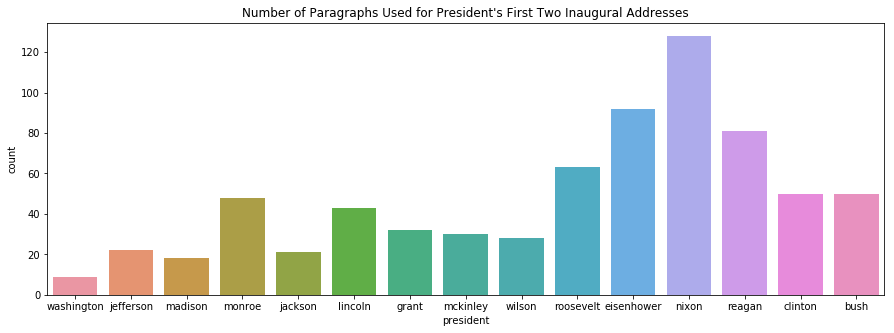

nixon         128
eisenhower     92
reagan         81
roosevelt      63
bush           50
clinton        50
monroe         48
lincoln        43
grant          32
mckinley       30
wilson         28
jefferson      22
jackson        21
madison        18
washington      9
Name: president, dtype: int64

In [28]:
# Previewing the paragraph-to-president distribution
plt.figure(figsize=[15,5])
sns.countplot(x=df_paragraphs.president)
plt.title("Number of Paragraphs Used for President's First Two Inaugural Addresses")
plt.show()
df_paragraphs.president.value_counts()

As before, we want to ensure that our model is exposed to the full gambit of selected presidents. Therefore, we will stratify our train-test split across paragraph-to-president distribution. 

Similarly, we see an overall paragraph-usage increase with the latter presidents, but the distribution doesn't appear quite as stark as the sentence distribution.

In [29]:
X = df_paragraphs['paragraphs']
y = df_paragraphs['president']

X_training, X_holdout, y_training, y_holdout = train_test_split(X, 
                                                    y,
                                                    stratify=y, # to ensure all presidents are in train and test
                                                    test_size=0.25, 
                                                    random_state=0)

In [30]:
y_test.value_counts()

reagan        80
mckinley      72
clinton       67
eisenhower    59
roosevelt     54
lincoln       54
nixon         52
wilson        39
grant         24
Name: text_source, dtype: int64

### Subsection 3C: Feature Creation and Engineering

In [31]:
vectorizer = TfidfVectorizer(max_df=0.90, # drop words in more than half the paragraphs
                             min_df=3, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Correction factor that treat long & short paragraphs equally
                             smooth_idf=True #Adds 1 to all document frequencies. Prevents divide-by-zero errors
                            )
feature_reduction = TruncatedSVD(500)
classifier = LogisticRegression()

### Subsection 3D: Clustering

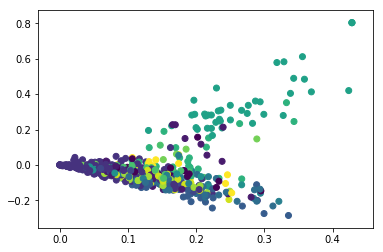

Comparing k-means clusters against the data:
col_0       0   1   2   3   4   5   6   7   8   9   10  11  12  13  14
president                                                             
bush         2   4  16   3   0   3   2   3   3   1   3   0   8   2   0
clinton      3   9   9   1   1   4   1   3   4   0   1   0   6   7   1
eisenhower   3   6  36   8  11   6   0  10   1   1   6   4   0   0   0
grant        1   1  12   0   0   1   2   2   1   4   3   0   0   1   4
jackson      0   0   5   0   1   1   6   0   3   1   2   0   0   0   2
jefferson    0   1   7   0   0   0   1   0   9   1   1   0   0   0   2
lincoln      0   0  18   0   2   0   1   3   1   6   0   0   0   0  12
madison      0   1   7   0   0   1   0   0   1   7   0   0   0   0   1
mckinley     0   1   9   0   1   1   5   0   3   3   5   1   0   1   0
monroe       1   0  16   0   1   0   5   0   5  12   3   0   0   0   5
nixon        9   9  36   7  12   6   8   9   2   2   6   5   5  12   0
reagan       3   4  33   0   4  

In [32]:
X_features = vectorizer.fit_transform(X)

# Normalize the data.
X_norm = normalize(X_features)

# Reduce it to two components.
X_svd = TruncatedSVD(2).fit_transform(X_norm)

# Calculate predicted values.
y_pred = KMeans(n_clusters=15, random_state=0).fit_predict(X_norm)

# Plot the solution.
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y, y_pred))

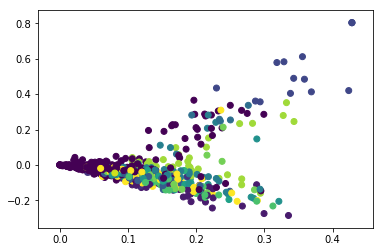

Comparing the assigned categories to the ones in the data:
col_0       0   1   2   3   4   5   6   7   8   9   10  11  12  13  14
president                                                             
bush        26   0   0   0   8   1   2   2   2   0   3   1   0   1   4
clinton     13   1   2   4   5   0   1   0   6   0   3   8   0   1   6
eisenhower  46  13   3   1   0   1   3   2   0   0   4   2   1   0  16
grant       20   0   0   1   0   0   4   1   1   0   0   0   4   0   1
jackson     11   1   0   0   0   0   2   3   0   0   1   0   3   0   0
jefferson   13   0   0   5   0   0   0   2   0   0   0   0   1   0   1
lincoln     29   2   0   0   0   0   0   1   0   0   0   0   9   0   2
madison     13   0   0   0   0   0   0   0   0   0   1   0   3   0   1
mckinley    14   1   0   0   0   0   6   3   0   0   0   0   5   0   1
monroe      25   1   0   1   0   0   7   6   0   0   0   0   8   0   0
nixon       50  13   0   0   7   2   7   8  11   0   4   8   1   0  17
reagan      40   3

In [33]:
# Clustering with Spectral Clustering
sc = SpectralClustering(n_clusters=15)
sc.fit(X_norm)

# Predicted clusters.
predict=sc.fit_predict(X_norm)

# Graph results.
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=predict)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y,predict))

### Subsection 3E: Classification Models

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_training, 
                                                    y_training,
                                                    stratify=y_training, # to ensure all presidents are in train and test
                                                    test_size=0.25, 
                                                   random_state=0)

In [35]:
# Setting up our pipeline with Logistic for train-test testing
vectorizer = TfidfVectorizer(max_df=0.5, # drop words in more than half the paragraphs
                             min_df=3, # only use words that appear at least three times
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Correction factor that treat long & short paragraphs equally
                             smooth_idf=True #Adds 1 to all document frequencies. Prevents divide-by-zero errors
                            )
feature_reduction = TruncatedSVD(350)
classifier = LogisticRegression()

text_clf = Pipeline([('vect', vectorizer),
                     ('svd', feature_reduction),
                     ('clf', classifier), ])

text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
print("Accuracy of predicted: ", np.mean(predicted == y_test))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy of predicted:  0.27611940298507465


In [36]:
# Setting up our pipeline with Logistic for train-test testing
classifier = LogisticRegression()

text_clf = Pipeline([('vect', vectorizer),
                     ('svd', feature_reduction),
                     ('clf', classifier), ])

text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
print("Accuracy of predicted: ", np.mean(predicted == y_test))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy of predicted:  0.27611940298507465


In [37]:
# Setting up our pipeline with KNN for train-test testing
classifier = neighbors.KNeighborsClassifier(weights='distance', n_neighbors=15)

text_clf = Pipeline([('vect', vectorizer),
                     ('svd', feature_reduction),
                     ('clf', classifier), ])

text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
print("Accuracy of predicted: ", np.mean(predicted == y_test))

Accuracy of predicted:  0.208955223880597


In [38]:
# Setting up our pipeline with Random Forest for train-test testing
classifier = ensemble.RandomForestClassifier(random_state=0)

text_clf = Pipeline([('vect', vectorizer),
                     ('svd', feature_reduction),
                     ('clf', classifier), ])

text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
print("Accuracy of predicted: ", np.mean(predicted == y_test))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy of predicted:  0.1417910447761194


In [39]:
# Setting up our pipeline with SVC for train-test testing
classifier = svm.SVC(kernel='linear')

text_clf = Pipeline([('vect', vectorizer),
                     ('svd', feature_reduction),
                     ('clf', classifier), ])

text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
print("Accuracy of predicted: ", np.mean(predicted == y_test))

Accuracy of predicted:  0.3208955223880597


Although all of the models performed with lower scores, there seems to be higher potential for the Support Vector Machine classifier when dealing with text through TF-IDF. Moving forward we will assess the two methods with highest potential and tune their parameters to see if we can increase their accuracy.

## Section 4: Assessing and Tuning Highest Potential Approaches
### Subsection 4A: BoW Model
With differences of scores as large as 50% between the training and test sets, there was clear overfitting or a large degree of homogenous features. If it is the former, applying PCA should help; if the latter, it may require more feature generation.

In [40]:
y = limited_presidents['text_source']
X = limited_presidents.drop(['text_sentence','text_source'], 1)

base = 0
for component in range(5,550,5):
    pca = PCA(n_components=component)
    X_pca = pca.fit_transform(X)  

    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.4, random_state=0)

    logistic = LogisticRegression(solver='liblinear', multi_class='auto')
    logistic.fit(X_train, y_train)
    
    if logistic.score(X_test, y_test) > base:
        base = logistic.score(X_test, y_test)
        components = component

print("The highest score on the test set was {} with {} PCA components.".format(base,components))

# Testing
pca = PCA(n_components=base)
X_pca = pca.fit_transform(X)  

X_train, X_test, y_train, y_test = train_test_split(X_pca, 
                                                    y,
                                                    test_size=0.4,
                                                    random_state=0)

The highest score on the test set was 0.4171656686626746 with 290 PCA components.


In [41]:
# Assessing potential of Logistic Regression
logistic = LogisticRegression(solver='lbfgs')
logistic.fit(X_train, y_train)
print('Training set score:', logistic.score(X_train, y_train))
print('\nTest set score:', logistic.score(X_test, y_test))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Training set score: 0.41544607190412786

Test set score: 0.36726546906187624


### Subsection 4B: TF-IDF Model
As before there is a large difference between training and test sets; this could be the result of overfitting or hoomogenous features. If it is the former, applying PCA should help; if the latter, it may require more feature generation.

In [42]:
limited = ['lincoln','grant','mckinley','wilson','roosevelt','eisenhower','nixon','reagan','clinton','Bush']
limited_presidents_tfidf = df_paragraphs[df_paragraphs.president.isin(limited)]

X = limited_presidents_tfidf['paragraphs']
y = limited_presidents_tfidf['president']

X_training, X_holdout, y_training, y_holdout = train_test_split(X, 
                                                    y,
                                                    stratify=y, # to ensure all presidents are in train and test
                                                    test_size=0.25, 
                                                    random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X_training, 
                                                    y_training,
                                                    stratify=y_training, # to ensure all presidents are in train and test
                                                    test_size=0.25, 
                                                   random_state=0)

In [43]:
vectorizer = TfidfVectorizer(max_df=0.5, # drop words in more than half the paragraphs
                             min_df=3, # only use words that appear at least three times
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Correction factor that treat long & short paragraphs equally
                             smooth_idf=True #Adds 1 to all document frequencies. Prevents divide-by-zero errors
                            )
feature_reduction = TruncatedSVD(200)
classifier = svm.SVC(kernel='linear', gamma='auto')

base = 0
for component in range(5,230,5):
    feature_reduction = TruncatedSVD(component)
    text_clf = Pipeline([('vect', vectorizer),
                         ('svd', feature_reduction),
                         ('clf', classifier), ])
    text_clf.fit(X_train, y_train)
    predicted = text_clf.predict(X_test)
    if np.mean(predicted == y_test) > base:
        base = np.mean(predicted == y_test)
        components = component

print("The highest score on the test set was {} with {} SVD components.".format(base,components))

The highest score on the test set was 0.4368932038834951 with 115 SVD components.


In [44]:
feature_reduction = TruncatedSVD(135)

text_clf = Pipeline([('vect', vectorizer),
                     ('svd', feature_reduction),
                     ('clf', classifier), ])

text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
print("Accuracy of predicted: ", np.mean(predicted == y_test))

Accuracy of predicted:  0.4368932038834951


## Section 5: Testing Tuned Models on Holdout
### Subsection 5A: Bag-of-Words Model

In [45]:
sentences

X = sentences['sentences']
y = sentences['president']

X_training, X_holdout, y_training, y_holdout = train_test_split(X,
                                                                y,
                                                                stratify=y, # to ensure all presidents are in train and test
                                                                test_size=0.25, 
                                                                random_state=0)

In [46]:
y = limited_presidents['text_source']
X = limited_presidents.drop(['text_source'], 1)

X_training, X_holdout, y_training, y_holdout = train_test_split(X, 
                                                    y,
                                                    stratify=y, # to ensure all presidents are in train and test
                                                    test_size=0.25, 
                                                   random_state=0)

In [47]:
limited = ['lincoln','grant','mckinley','wilson','roosevelt','eisenhower','nixon','reagan','clinton','Bush']
limited_presidents = word_counts[word_counts.text_source.isin(limited)]

y = limited_presidents['text_source']
X = limited_presidents.drop(['text_sentence','text_source'], 1)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.4,
                                                    random_state=0)

In [51]:
# Concatenating training data for BoW function input
training_sentences = pd.concat([X_training, y_training], axis=1).reset_index(drop=True)
holdout_sentences = pd.concat([X_holdout, y_holdout], axis=1).reset_index(drop=True)

In [52]:
# Creating train-test split of original training data
y_training = limited_presidents['text_source']
X_training = np.array(limited_presidents.drop(['text_sentence','text_source'], 1))

y_holdout = holdout_sentences['text_source']
X_holdout = np.array(holdout_sentences.drop(['text_sentence','text_source'], 1))

In [53]:
# Assessing potential of Logistic Regression
logistic = LogisticRegression()
logistic.fit(X_training, y_training)
print('Training set score:', logistic.score(X_training, y_training))
print('Test set score:', logistic.score(X_holdout, y_holdout))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Training set score: 0.7675718849840255
Test set score: 0.7955271565495208


### Subsection 5B: TF-IDF Model

In [54]:
X = df_paragraphs['paragraphs']
y = df_paragraphs['president']

X_training, X_holdout, y_training, y_holdout = train_test_split(X, 
                                                    y,
                                                    stratify=y, # to ensure all presidents are in train and test
                                                    test_size=0.25, 
                                                    random_state=0)

In [55]:
# Setting up our pipeline with Logistic for train-test testing
vectorizer = TfidfVectorizer(max_df=0.5, # drop words in more than half the paragraphs
                             min_df=3, # only use words that appear at least three times
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Correction factor that treat long & short paragraphs equally
                             smooth_idf=True #Adds 1 to all document frequencies. Prevents divide-by-zero errors
                            )
feature_reduction = TruncatedSVD(120)
classifier = svm.SVC(kernel='linear', gamma='auto')

text_clf = Pipeline([('vect', vectorizer),
                     ('svd', feature_reduction),
                     ('clf', classifier), ])

text_clf.fit(X_training, y_training)
print('Training set score:', text_clf.score(X_training, y_training))
predicted = text_clf.predict(X_holdout)
print("Test set score: ", np.mean(predicted == y_holdout))

Training set score: 0.5317164179104478
Test set score:  0.2737430167597765


In [56]:
limited = ['lincoln','grant','mckinley','wilson','roosevelt','eisenhower','nixon','reagan','clinton','Bush']
limited_presidents = df_paragraphs[df_paragraphs.president.isin(limited)]

y = limited_presidents['president']
X = limited_presidents['paragraphs']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.4,
                                                    random_state=0)

In [57]:
text_clf.fit(X_training, y_training)
print('Training set score:', text_clf.score(X_training, y_training))
predicted = text_clf.predict(X_holdout)
print("Test set score: ", np.mean(predicted == y_holdout))

Training set score: 0.5298507462686567
Test set score:  0.2737430167597765


## Section 6: Final Test on Extra Data

Initially, the model of greater promise seemed to be the TF-IDF Vectorizer. When trained on the training set, it was able to score the training data with greater accuracy as well as the testing data of the training set. In contrast, the BoW model was not nearly as accurate on the training data and was a slightly worse performer on the testing data of the training set. However, when the holdout group was introduced, the BoW model performed at at 29% while the TF-IDF model was almost at 27%.

To provide one last comparison of models, we still have two speeches from Roosevelt. Therefore, these speeches will be loaded according to both methods to see how accurate the models are when given speeches that are unseen and only from one president.

### Subsection 6A: Bag-of-Words Model

In [58]:
roosevelt_speeches = ['1941-Roosevelt.txt','1945-Roosevelt.txt']
# Creating a list of relevant, unique names to identify each address specifically
roosevelt_speech_names = []
for name in roosevelt_speeches:
    roosevelt_speech_names.append(re.sub("[^a-zA-Z]",'',name[5:-4]).lower() +'_'+ re.sub("",'',name[:4]))

# Loading all addresses within list 'speeches' and titling each according to list 'speech_names'
roosevelt_addresses={}
for speech_name, speech in zip(roosevelt_speech_names, roosevelt_speeches):
    roosevelt_addresses[speech_name] = inaugural.raw(speech)

print('For this final testing, the remaining {} addresses by Roosevelt will be used.'.format(len(roosevelt_addresses)))

For this final testing, the remaining 2 addresses by Roosevelt will be used.


In [59]:
# Loading dictionary into DataFrame for text-cleaning
df_roosevelt = pd.DataFrame.from_dict(roosevelt_addresses, orient='index', columns=['address'])

# Creating list and adding to DataFrame for target variable of the Roosevelt's name
df_roosevelt['target'] = 'roosevelt'

df_roosevelt.head()

,address,target
roosevelt_1941,On each national day of inauguration since 178...,roosevelt
roosevelt_1945,"Chief Justice, Mr. Vice President, my friends,...",roosevelt


In [60]:
# Creating list of cleaned addresses according to function 'text_cleaner'
cleaned = [text_cleaner(address) for address in df_roosevelt.address]

# Replacing old text data of addresses with cleaned text data
df_roosevelt['address'] = cleaned
df_roosevelt.head()

,address,target
roosevelt_1941,On each national day of inauguration since 178...,roosevelt
roosevelt_1945,"Chief Justice, Mr. Vice President, my friends,...",roosevelt


In [61]:
# Creating list for parsed addresses
parsed = [nlp(address) for address in df_roosevelt.address]

# Replacing cleaned text with parsed text
df_roosevelt['address'] = parsed
df_roosevelt.head()

,address,target
roosevelt_1941,"(On, each, national, day, of, inauguration, si...",roosevelt
roosevelt_1945,"(Chief, Justice, ,, Mr., Vice, President, ,, m...",roosevelt


In [62]:
# Creating for loop create DataFrame of address sentences with respective target president from address paragraphs
sentences_roosevelt = pd.DataFrame()
for x in range(0, len(df_roosevelt.address)):
    if x == 0:
        sentences_roosevelt['sentences'] = [sent for sent in df_roosevelt.address[x].sents]
        sentences_roosevelt['president'] = df_roosevelt.target[x]
    else:
        temporary = pd.DataFrame()
        temporary['sentences'] = [sent for sent in df_roosevelt.address[x].sents]
        temporary['president'] = df_roosevelt.target[x]
        sentences_roosevelt = sentences_roosevelt.append(temporary)
        sentences_roosevelt = sentences_roosevelt.reset_index(drop=True)

sentences_roosevelt.tail()

,sentences,president
96,"(We, can, gain, it, only, if, we, proceed, wit...",roosevelt
97,"(The, Almighty, God, has, blessed, our, land, ...",roosevelt
98,"(He, has, given, our, people, stout, hearts, a...",roosevelt
99,"(He, has, given, to, our, country, a, faith, w...",roosevelt
100,"(So, we, pray, to, Him, now, for, the, vision,...",roosevelt


In [63]:
# Creating feature word counts on Roosevelt data
roosevelt_word_counts = bow_features(sentences_roosevelt, common_words)

Processing row 0
Processing row 100


In [64]:
# Creating train-test split of original training data
y_train = word_counts['text_source']
X_train = np.array(word_counts.drop(['text_sentence','text_source'], 1))
y_test = roosevelt_word_counts['text_source']
X_test = np.array(roosevelt_word_counts.drop(['text_sentence','text_source'], 1))

In [65]:
# Assessing potential of Logistic Regression
logistic = LogisticRegression()
logistic.fit(X_train, y_train)
print('Training set score:', logistic.score(X_train, y_train))
print('\nTest set score:', logistic.score(X_test, y_test))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Training set score: 0.7498591549295774

Test set score: 0.1485148514851485


### Subsection 6B: TF-IDF Model

In [66]:
# Loading all addresses in paragraph form within list 'speeches' and titling each according to appropriate president
roosevelt_address_paragraphs=[]
for speech in roosevelt_speeches:
    for paragraph in inaugural.paras(speech):
        paragraph_assigned = [paragraph, 'roosevelt']
        roosevelt_address_paragraphs.append(paragraph_assigned)

# Loading into DataFrame for easy manipulation
roosevelt_df_paragraphs = pd.DataFrame(roosevelt_address_paragraphs, columns=['paragraphs','president'])

roosevelt_df_paragraphs.head()

,paragraphs,president
0,"[[On, each, national, day, of, inauguration, s...",roosevelt
1,"[[In, Washington, ', s, day, the, task, of, th...",roosevelt
2,"[[In, Lincoln, ', s, day, the, task, of, the, ...",roosevelt
3,"[[In, this, day, the, task, of, the, people, i...",roosevelt
4,"[[To, us, there, has, come, a, time, ,, in, th...",roosevelt


In [67]:
roosevelt_address_paras = []
paragraph_split(roosevelt_df_paragraphs.paragraphs, roosevelt_address_paras)

# Replacing raw paragraph data with cleaned data
roosevelt_df_paragraphs['paragraphs'] = roosevelt_address_paras
roosevelt_df_paragraphs.head()

,paragraphs,president
0,On each national day of inauguration since 178...,roosevelt
1,In Washington ' s day the task of the people w...,roosevelt
2,In Lincoln ' s day the task of the people was ...,roosevelt
3,In this day the task of the people is to save ...,roosevelt
4,"To us there has come a time , in the midst of ...",roosevelt


In [68]:
X_train = df_paragraphs['paragraphs']
y_train = df_paragraphs['president']
X_test = roosevelt_df_paragraphs['paragraphs']
y_test = roosevelt_df_paragraphs['president']

In [69]:
vectorizer = TfidfVectorizer(max_df=0.90, # drop words in more than half the paragraphs
                             min_df=3, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Correction factor that treat long & short paragraphs equally
                             smooth_idf=True #Adds 1 to all document frequencies. Prevents divide-by-zero errors
                            )
feature_reduction = TruncatedSVD(350)
classifier = LogisticRegression()

text_clf = Pipeline([('vect', vectorizer),
                     #('svd', feature_reduction),
                     ('clf', classifier), ])

text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
print("Accuracy of predicted: ", np.mean(predicted == y_test))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy of predicted:  0.16666666666666666


## Section 7: Conclusion

The task of this project was, admittedly, a difficult one for various reasons, chief among them being the similarity of each of the samples (all texts were shorter inaugural addresses delivered by United States Presidents). There didn't seem to be very many distinguishing factors between each of the presidents.

Indeed, this similarity is noticeable in the unsupervised clustering. While some presidents stand out more than others (like Eisenhower and Wilson as well as McKinley and Monroe) in this method, the majority of presidents seem to blend in with the others without distinction.

Moving forward into the modeling, the initial accuracy of our tests were incredibly poor ranging from 11%-35% with the highest score coming from the Logistic Regression used as a Classifier. While both models covering Bag-of-Words and TF-IDF Vectorizer performed slightly better than a random chance model (which would perform around 6.7% given the fact that we were classifying 15 presidents). Then, as to be expected, when we reduced our potential target variables to the most recent 10 presidents (who also happened to have larger data samples by which we could create and test our models), our score increased - but only slightly.

Finally, under Subsection 5A where we implemented our holdout sample into the model, we saw a drastic improvement and consistency in score:
- Training set score: 0.7675718849840255
- Test set score: 0.7955271565495208

The reason for this irregularly high score could be attributed to several things, but I believe it to be the increase of data input used to tune the model. When creating the model in this subsection, the model was retuned to the entirety of the training data (not just the training set of the training data) and then tested on the entirety of the holdout. However, after implementing an additional test of Roosevelt's two remaining speeches, the model performed as poorly as the initial models. Therefore, with the progress made so far, we can only remain cautiously optimistic about creating a model that consistently provides high accuracy.